#### Functions (IGNORE)

In [1]:
# import packages that will be used for analysis
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

##### Get Stock Data

In [2]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [3]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [4]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### Stochastic Modeling

In [5]:
def stochastic_modeling(nested_dict, tickers, periods,num_samples,investment_period):
    # Store the returns in a nested dictionary
    nested_dict_returns = {period: {ticker: [] for ticker in tickers} for period in periods}

    # Go through each economic time period
    for period in periods:
        max_index = len(nested_dict[period]) - investment_period  # Ensure there's enough data to calculate ROI

        # Generate random samples from the valid range
        random_dates = random.choices(range(max_index), k=num_samples)

        for ticker in tickers:
            for date_idx in random_dates:
                start_price = nested_dict[period][ticker].iloc[date_idx]
                end_price = nested_dict[period][ticker].iloc[date_idx + investment_period]

                # Get the return by the Holding Period Return
                roi = (((end_price - start_price) / start_price) * 100)

                nested_dict_returns[period][ticker].append(roi)

    return nested_dict_returns  # Return the nested dictionary with returns

In [6]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

##### Plot Data

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot percentage-based histogram
def plot_percentage_histogram(data, title, xlabel, ylabel, bins=10, color='skyblue'):
    """
    Plots a percentage-based histogram for the given data.

    Parameters:
    data (array-like): Data to plot the histogram for.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    bins (int): Number of bins for the histogram.
    color (str): Color for the histogram bars.
    """
    # Set modern aesthetic
    sns.set_style("whitegrid")

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color=color, edgecolor='black',
             weights=np.ones_like(data) / len(data))

    # Convert y-axis to percentages
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

    # Add titles and labels with improved font sizes
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Add gridlines for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Chapter 1: Buy and Hold Strategy
A Buy and Hold Strategy is an investment approach where an investor purchases stocks or other assets and holds onto them for an extended period, regardless of short-term market fluctuations. This strategy operates on the assumption that, over time, the market tends to increase in value, thus yielding returns on investments held over years. It's particularly popular among novice investors for its simplicity and potential to minimize the stress of frequent trading decisions.

## Buy and Hold Strategy using Sector ETF's
Sector ETFs are the accumulation of a variety of stocks within one of the 11 GICS Sectors (see documentation). They are meant to be a representation of a sector's overall movement. This will allow for a better understanding of which sectors perform best over time. To add further complexity, different economic time periods will be used to evaluate the changing success of an investment based on macroeconomic environments. For example some stocks out perform benchmarks during a recession due to their defensive nature such as the Health Care ETF (XLV).

## Sector ETF and Time Period Setup

In [24]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
    'all_data': ('2005-01-01','2024-06-01')
}

economic_cycle_periods_list = ['trough','expansion','peak','contraction','all_data']

In [9]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [10]:
# save nested dictionary data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

## Perform Stochastic Modeling using Buy and Hold Strategies
Using stochastic modeling is essential for financial investment backtesting. When you have a strategy it needs to be tested in lots of different environments. By having different buy days with a set investment period, this is going to reduce the deviation in returns. You should get a distribution of how the returns is spread over many iterations as well as the deviation from the average.

### Get Sector ETF Adjusted Close
The only data that is required for this investigation is the adjusted close price. This data can create a dataframe in which the columns are populated by adjusted closed price for stocks on days of the sample.

In [11]:
# using the function 'get_adjusted_closed_price' you can create a nested dictionary which can go into different periods to get adjusted close data
sector_etf_adjusted_close = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

In [12]:
# 'sector_etf_adjusted_close' is now a dataframe that can be accessed during different business cycles
trough_adjusted_close = sector_etf_adjusted_close['trough']
trough_adjusted_close

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2008-10-01,23.119263,21.858324,12.413445,15.649681,22.589596,18.009504,37.393250,22.927481,36.648041,18.666506,34.011742
2008-10-02,21.458340,20.549891,11.794873,15.037060,21.771833,17.782764,35.261120,22.965391,35.561859,18.395731,31.759153
2008-10-03,21.247196,20.222771,11.278401,14.822242,21.010752,17.640247,34.840694,22.472725,35.039410,18.119316,30.064146
2008-10-06,20.198572,19.692133,10.689857,14.002764,20.419703,17.128458,32.966835,21.631418,33.396397,17.233658,29.512152
2008-10-07,19.156969,19.037899,9.560819,13.286714,19.108046,16.584291,31.159033,21.108442,31.966482,16.528517,27.019821
...,...,...,...,...,...,...,...,...,...,...,...
2009-05-22,18.848721,16.073530,7.178294,13.618086,18.520382,15.070187,29.497366,19.404512,33.037392,14.918159,18.541613
2009-05-26,19.300220,16.658962,7.412233,13.971802,19.143747,15.260787,30.122383,19.580990,34.221859,15.351318,19.500561
2009-05-27,18.576372,16.117989,7.190604,13.835139,18.725447,14.873023,29.794701,19.381498,33.881416,15.039446,18.851517


Text(0.5, 1.0, 'Sector ETF Adjusted Close during Trough')

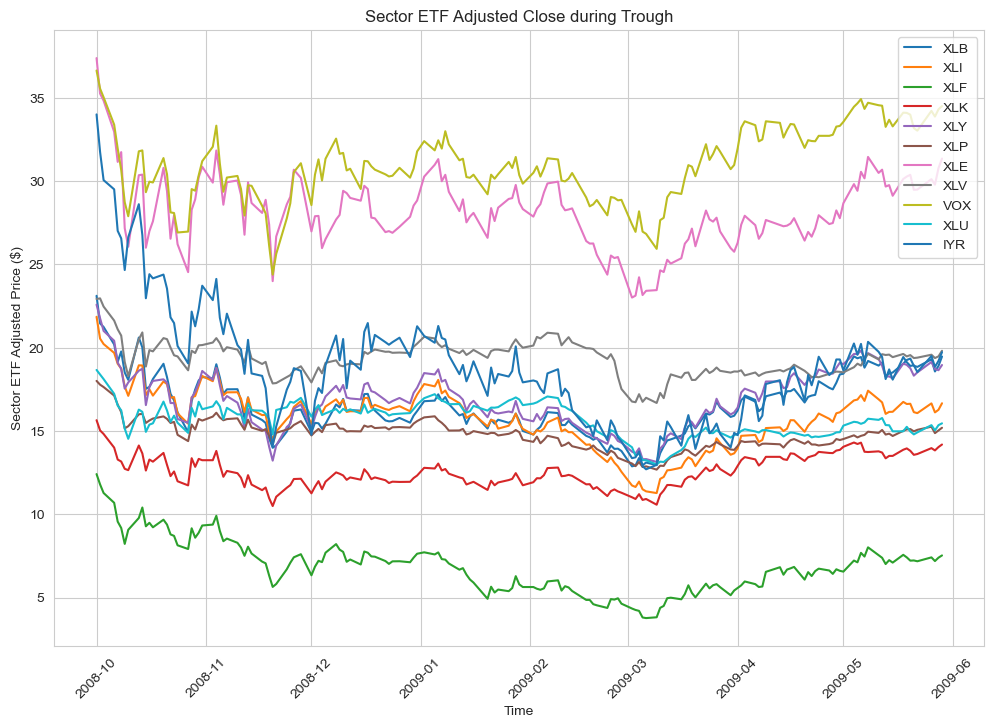

In [20]:
# a plot of adjusted close price of tickers during trough
plt.figure(figsize=(12,8))
for idx,ticker in enumerate(trough_adjusted_close.columns):
    plt.plot(trough_adjusted_close[ticker],label=f'{ticker}')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Sector ETF Adjusted Price ($)')
plt.legend()
plt.title('Sector ETF Adjusted Close during Trough')

### Stochastic Model
The stochastic model is going to perform the following methdology.

1. Choose 10000 start dates (within each business cycle) 
2. Loop through each start day
3. Purchase 1 stock of each sector ETF and hold onto it for 90 calendar days
4. Get the ROI from the stock investment

In [21]:
# save the nested dictionary of returnings for each ticker in each period using 10000 sample days across a 90 day investment period
period_return = stochastic_modeling(sector_etf_adjusted_close,sector_etf_tickers,economic_cycle_periods_list,10000,90)

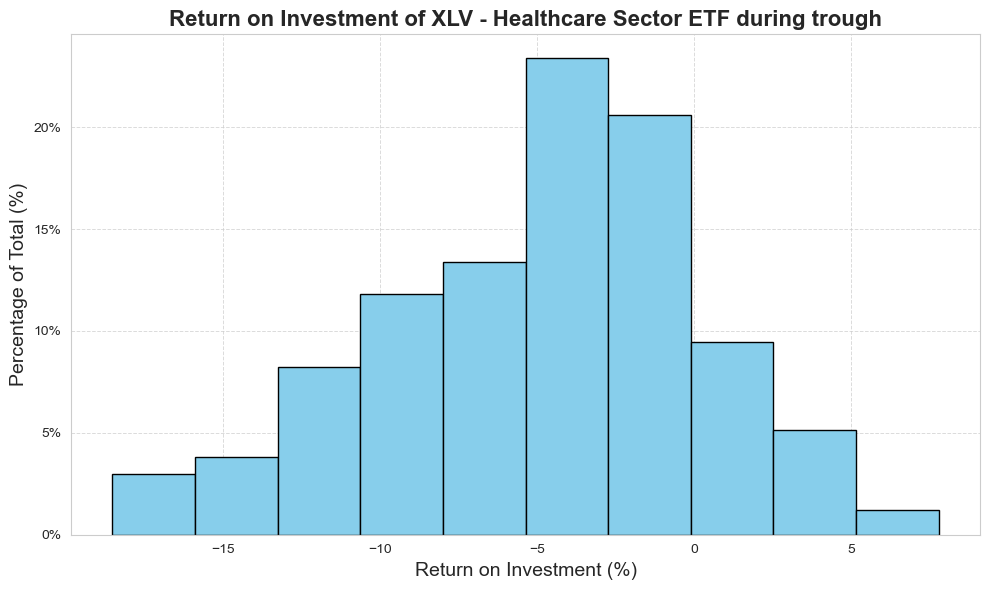

In [22]:
# plot the histogram of the XLV healthcare during a trough
plot_percentage_histogram(
    data=period_return['trough']['XLV'],
    title=f'Return on Investment of XLV - Healthcare Sector ETF during trough',
    xlabel='Return on Investment (%)',
        ylabel='Percentage of Total (%)'
)

In [16]:
# get the average returns from the list of sectors during different time periods
mean_average_return = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,period_return,'Mean')
mean_average_return

,trough,expansion,peak,contraction,all_data
XLB,-1.064495,4.979527,4.188008,-0.32123,3.944755
XLI,-13.284115,6.464632,6.918579,-4.535156,4.372334
XLF,-21.83167,7.417343,9.668537,-15.511792,3.252801
XLK,3.31728,5.664431,12.701312,-2.841855,5.932229
XLY,-1.193952,7.09759,3.471831,-4.200303,4.67005
XLP,-8.196526,5.863069,5.207061,0.49211,3.462648
XLE,-4.726092,3.631232,-0.273897,3.535435,3.975506
XLV,-4.733877,9.185574,8.596328,-3.832189,4.046522
VOX,4.171252,5.434144,6.197651,-5.491315,3.334933
XLU,-8.692614,4.956183,6.30816,-2.758492,3.174207


In [25]:
mean_average_return.mean()

trough        -6.701383
expansion      5.915004
peak           6.118114
contraction   -3.231339
all_data       3.945374
dtype: float64

In [17]:
std_average_return = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,period_return,'Std')
std_average_return

,trough,expansion,peak,contraction,all_data
XLB,17.972399,5.474867,3.117157,10.661207,11.85522
XLI,12.311095,5.708901,3.265997,6.953038,11.12007
XLF,24.564174,5.729303,4.757598,6.712705,14.534847
XLK,12.951741,4.518308,5.498791,7.908915,10.629056
XLY,15.013168,5.335813,3.233997,6.037021,10.957167
XLP,5.888703,4.372726,1.551857,2.679588,6.113985
XLE,9.662532,8.940841,6.332909,15.13302,15.557247
XLV,5.16577,4.506533,5.767607,6.434492,7.439571
VOX,9.912841,5.263906,3.604169,7.170781,10.527509
XLU,4.614458,5.984067,2.044658,6.747162,7.676685


In [26]:
std_average_return.mean()

trough         12.418688
expansion       5.651320
peak            3.761315
contraction     7.693310
all_data       10.809621
dtype: float64

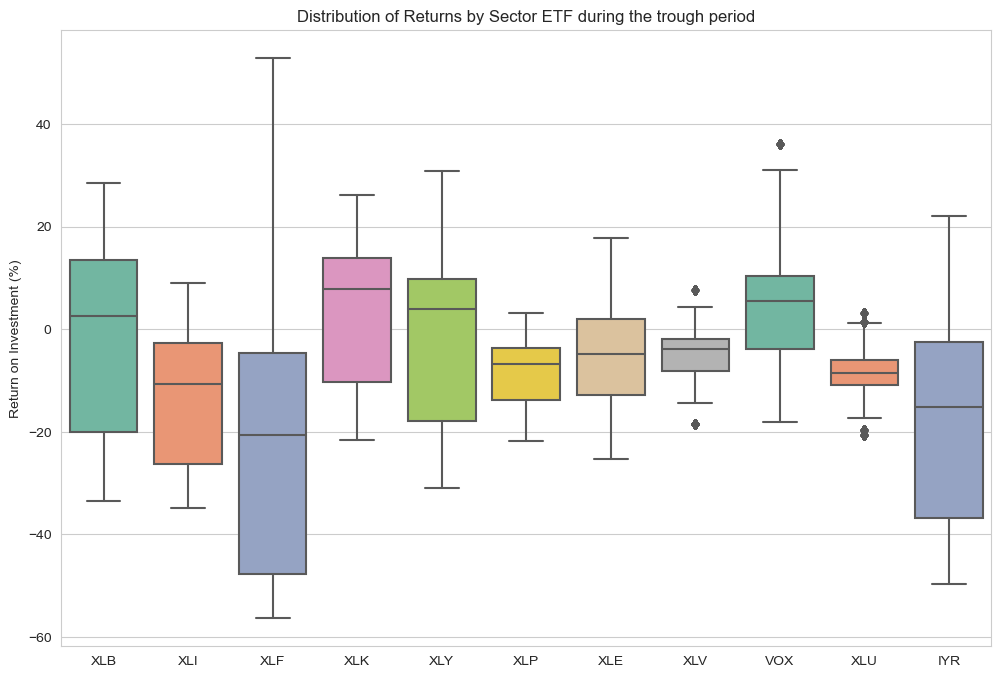

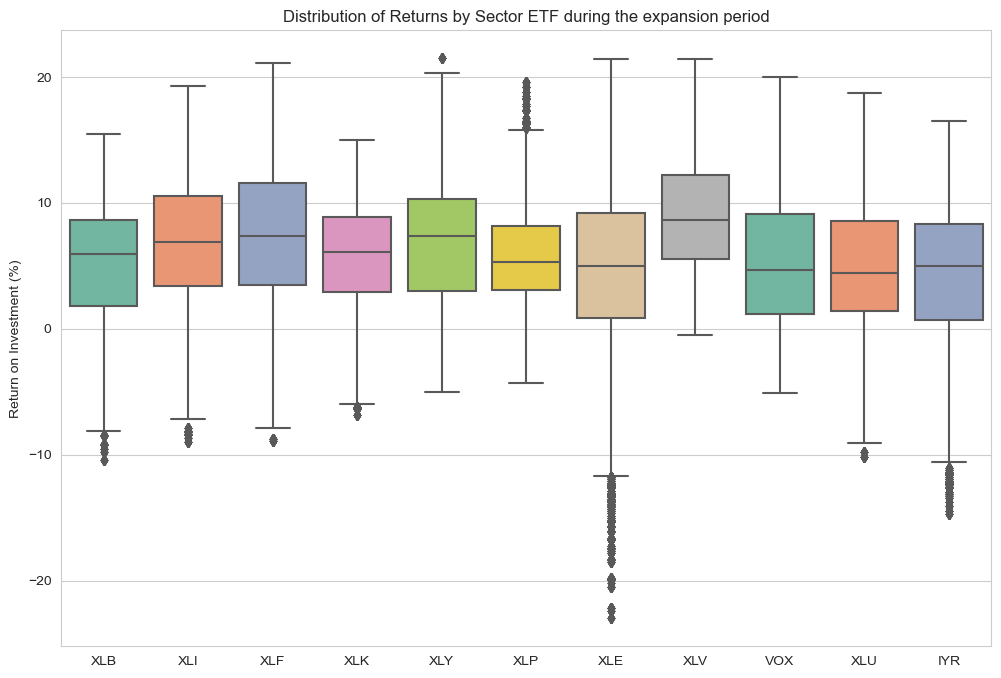

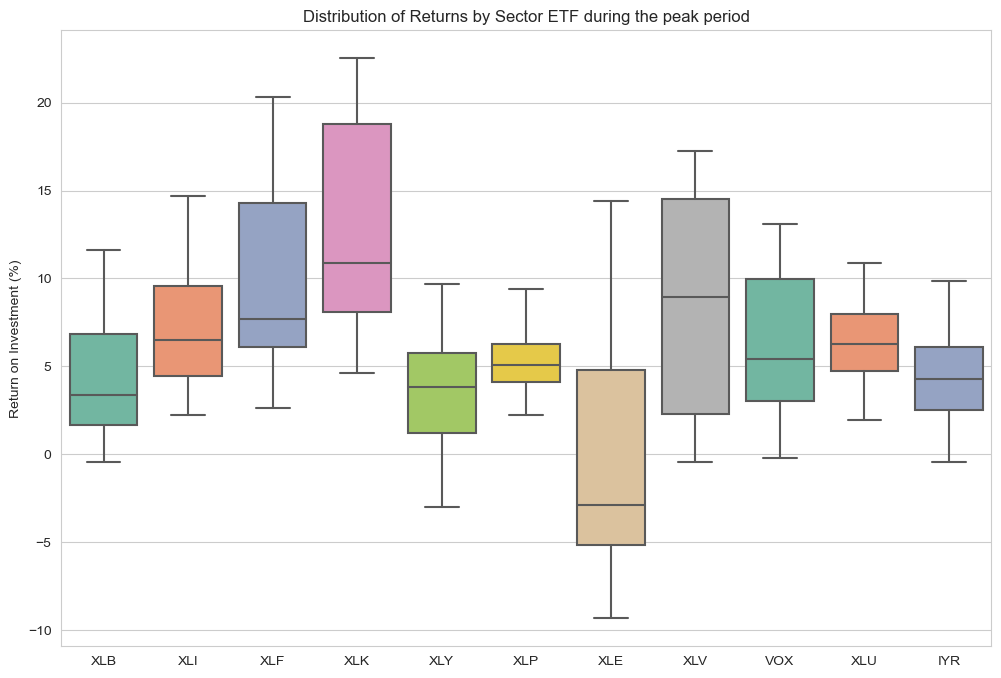

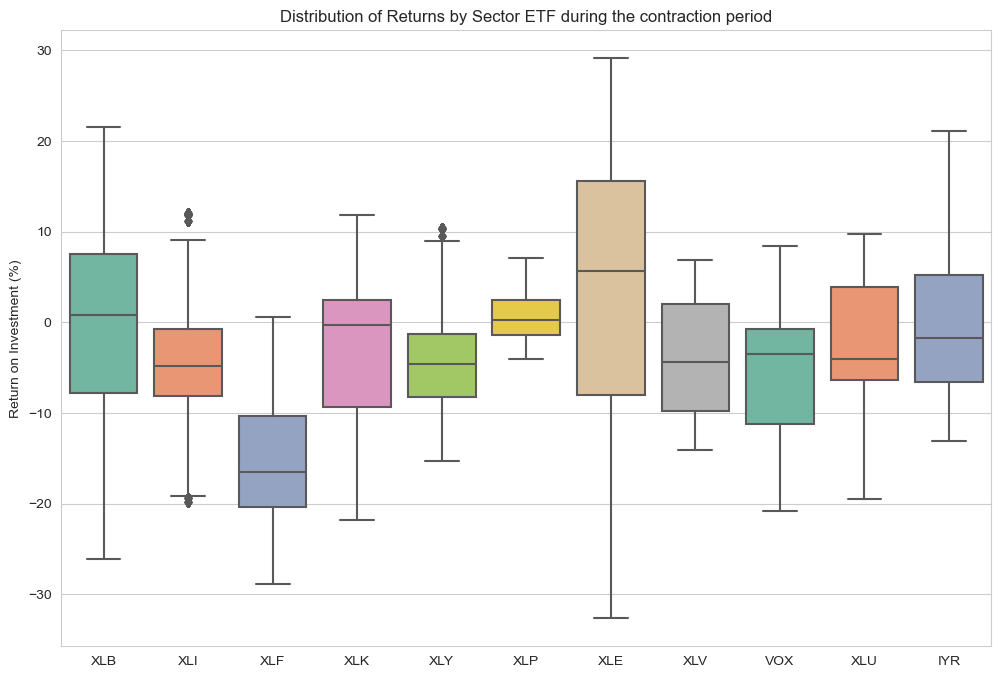

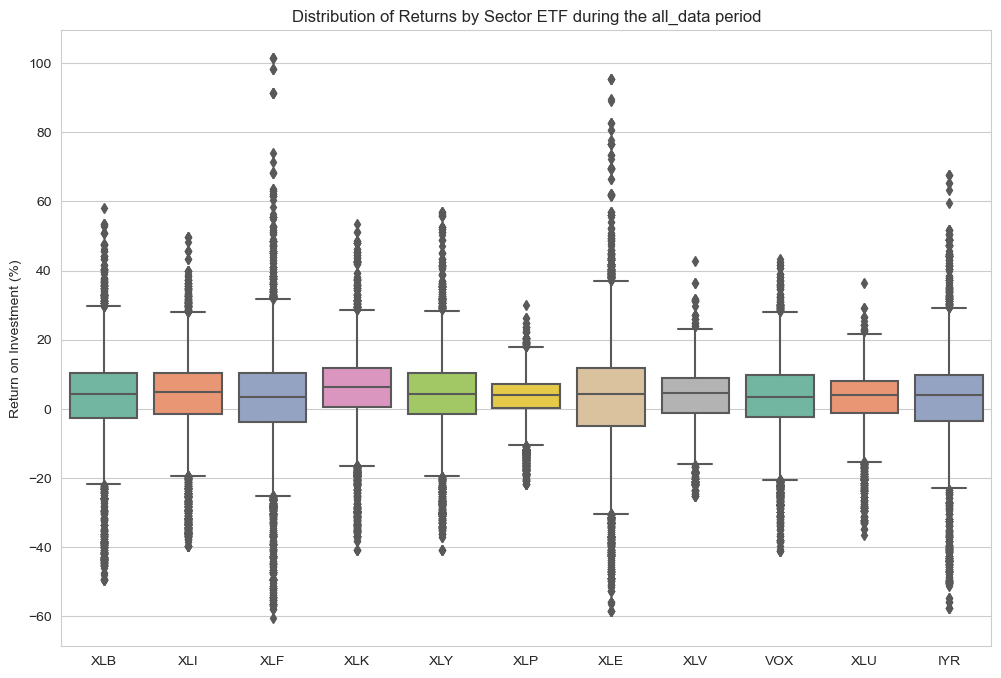

In [23]:
# create a boxplot of the above information for visualization
for period in economic_cycle_periods_list:
        # Boxplot of returns for each sector during the trough
        plt.figure(figsize=(12,8))
        sns.boxplot(data=[period_return[period][ticker] for ticker in sector_etf_tickers], palette='Set2')
        plt.xticks(range(len(sector_etf_tickers)), sector_etf_tickers)
        plt.title(f'Distribution of Returns by Sector ETF during the {period} period')
        plt.ylabel('Return on Investment (%)')
        plt.show()

### Conclusion
The buy and hold strategy is a simple yet effective strategy over the long term. However, it is clear that there are certain improvements that are made during different macreconomic cycles. During an expansion most stocks increase by a greater amount than during a constraction. The standard deviation also seems to be far greater during troughs which means that the expected return is much more volatile.

The full analysis can be found in the report.